In [161]:
#"user-read-private user-read-email user-read-playback-state user-read-currently-playing user-library-read"
#export SPOTIPY_CLIENT_ID='c27d762046d144e48d9d7d929e9c2206'
#export SPOTIPY_CLIENT_SECRET='fd9583d5356249e1a32e262640b989dc'
#export SPOTIPY_REDIRECT_URI='http://localhost/8888'

# 'user-library-read playlist-read-private'
'''
user-read-private \
user-read-email \
user-read-recently-played \
user-read-playback-state \
user-read-currently-playing \
user-library-read \
playlist-modify-public \
playlist-read-private \
user-follow-read \
user-top-read streaming
'''
    
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util


client_id ="c27d762046d144e48d9d7d929e9c2206" 
client_secret = "fd9583d5356249e1a32e262640b989dc"
redirect_uri = "https://localhost/8888"
username = ""
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
scope = 'user-library-read \
        playlist-read-private' 
token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

    
if token:
    # timeit library to measure the time needed to run this code
    import time
    start = time.time()
    
    # create empty lists where the results are going to be stored
    artist_name = []
    track_name = []
    popularity = []
    track_id = []
    num_tracks = 3500
    sp = spotipy.Spotify(auth=token)
    
    for i in range(0,num_tracks,50):
        track_results = sp.current_user_saved_tracks(limit=50,offset=i)
        for item in track_results['items']:
            track = item['track']
            artist_name.append(track['artists'][0]['name'])
            track_name.append(track['name'])
            track_id.append(track['id'])
            popularity.append(track['popularity'])
        
    stop = time.time()
    print ('Time to run this code (in seconds):', stop - start)
    
else:
    print("Can't get token for", username)
    

Time to run this code (in seconds): 14.758267164230347


Checking `track_id` list

In [174]:
print('number of elements in track_id list:', len(track_id))

number of elements in track_id list: 3143


Loading data into a dataframe

In [176]:
import pandas as pd

df_tracks = pd.DataFrame({'artist_name':artist_name, 
                          'track_name':track_name, 
                          'track_id':track_id, 
                          'popularity':popularity})
print(df_tracks.shape)
df_tracks.head()

(3143, 4)


,artist_name,track_name,track_id,popularity
0,Teho,Into the Wild,00VpPJg7gluM0dO4u7K9fZ,36
1,Harry Jay-Steele,Reach You,5VIYGFUngL0tTKFlAbXIbg,40
2,Ajmw,Thoughts,1ZMeEr88b1LJJYoDB2GOI0,31
3,Jason Barty,Burnet Moth,6kSYWuonprvsCJjg5VjTBz,34
4,Crooked Colours,Perfect Run,0rfsAaOLy1gUgCEhUilWTU,39


Let's view some information about the dataframe:

In [177]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 4 columns):
artist_name    3143 non-null object
track_name     3143 non-null object
track_id       3143 non-null object
popularity     3143 non-null int64
dtypes: int64(1), object(3)
memory usage: 98.3+ KB


## Checking Our Data
There can be duplicates of the same track under different IDs.  This is caused by the track being released in single albums and full albums. 

In [178]:
df_tracks[df_tracks.duplicated(subset=['artist_name','track_name'],keep=False)].count()

artist_name    183
track_name     183
track_id       183
popularity     183
dtype: int64

In [179]:
# group the entries by artist_name and track_name and check for duplicates

duplicates = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
print("Number of duplicate tracks: ", duplicates[duplicates > 1].count() )


Number of duplicate tracks:  90


Dropping duplicate tracks:

In [180]:
df_tracks.drop_duplicates(subset=['artist_name', 'track_name'], inplace=True)

Check again for duplicates:

In [181]:
# group the entries by artist_name and track_name and check for duplicates

duplicates = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
print("Number of duplicate tracks: ", duplicates[duplicates > 1].count() )


Number of duplicate tracks:  0


Now to check the shape of our data:

In [182]:
df_tracks.shape

(3050, 4)

# 4. Retrieve Audio Features Data
Using the [audio features endpoint](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/) we can retrieve the audio features data for the tracks we have collected.

There is a 100 track ID limit per query for this endpoint.  We can use anested for loop to pull track IDs in batches of size 100. 

In [183]:
# Measuring time
start = time.time()

rows = []
batchsize = 100
None_counter = 0

for i in range(0, len(df_tracks['track_id']), batchsize): 
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    
    for i, t in enumerate(feature_results):
        if t == None:
            None_counter = None_counter + 1
        else:
            rows.append(t)
            
print('Number of tracks where no audio features were available:', None_counter)

stop = time.time()
print ('Code runtime (sec):', stop - start)

Number of tracks where no audio features were available: 0
Code runtime (sec): 6.164048910140991


In [186]:
print('Number of elements in audio_features list:', len(rows))

Number of elements in audio_features list: 3050


In [187]:
df_audio_features = pd.DataFrame.from_dict(rows, orient='columns')
print("Shape of dataset:", df_audio_features.shape)
df_audio_features.head()

Shape of dataset: (3050, 18)


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.1060,https://api.spotify.com/v1/audio-analysis/00Vp...,0.748,488716,0.406,00VpPJg7gluM0dO4u7K9fZ,0.9210,7,0.0859,-13.741,0,0.0400,123.993,4,https://api.spotify.com/v1/tracks/00VpPJg7gluM...,audio_features,spotify:track:00VpPJg7gluM0dO4u7K9fZ,0.0515
1,0.7900,https://api.spotify.com/v1/audio-analysis/5VIY...,0.655,273945,0.570,5VIYGFUngL0tTKFlAbXIbg,0.0017,2,0.1840,-11.348,1,0.0463,119.930,4,https://api.spotify.com/v1/tracks/5VIYGFUngL0t...,audio_features,spotify:track:5VIYGFUngL0tTKFlAbXIbg,0.3770
2,0.2080,https://api.spotify.com/v1/audio-analysis/1ZMe...,0.523,141395,0.234,1ZMeEr88b1LJJYoDB2GOI0,0.5990,0,0.1280,-11.405,1,0.2040,86.275,4,https://api.spotify.com/v1/tracks/1ZMeEr88b1LJ...,audio_features,spotify:track:1ZMeEr88b1LJJYoDB2GOI0,0.1820
3,0.6360,https://api.spotify.com/v1/audio-analysis/6kSY...,0.705,205458,0.418,6kSYWuonprvsCJjg5VjTBz,0.8740,7,0.0894,-14.443,1,0.0857,89.982,4,https://api.spotify.com/v1/tracks/6kSYWuonprvs...,audio_features,spotify:track:6kSYWuonprvsCJjg5VjTBz,0.3800
4,0.0214,https://api.spotify.com/v1/audio-analysis/0rfs...,0.612,368047,0.651,0rfsAaOLy1gUgCEhUilWTU,0.4510,9,0.0727,-9.937,0,0.0443,117.006,4,https://api.spotify.com/v1/tracks/0rfsAaOLy1gU...,audio_features,spotify:track:0rfsAaOLy1gUgCEhUilWTU,0.0281


Renaming `id` to `track_id` to match the `df_tracks` dataframe:

In [188]:
df_audio_features.rename(columns = {'id': 'track_id'}, inplace=True)
df_audio_features.shape # checking our progress

(3050, 18)

To combine the two dataframes we do an inner merge to only keep track IDs that are in both datasets.

In [202]:
df = pd.merge(df_tracks, df_audio_features, on='track_id', how='inner')
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (3050, 21)


,artist_name,track_name,track_id,popularity,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,...,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,Teho,Into the Wild,00VpPJg7gluM0dO4u7K9fZ,36,0.1060,https://api.spotify.com/v1/audio-analysis/00Vp...,0.748,488716,0.406,0.9210,...,0.0859,-13.741,0,0.0400,123.993,4,https://api.spotify.com/v1/tracks/00VpPJg7gluM...,audio_features,spotify:track:00VpPJg7gluM0dO4u7K9fZ,0.0515
1,Harry Jay-Steele,Reach You,5VIYGFUngL0tTKFlAbXIbg,40,0.7900,https://api.spotify.com/v1/audio-analysis/5VIY...,0.655,273945,0.570,0.0017,...,0.1840,-11.348,1,0.0463,119.930,4,https://api.spotify.com/v1/tracks/5VIYGFUngL0t...,audio_features,spotify:track:5VIYGFUngL0tTKFlAbXIbg,0.3770
2,Ajmw,Thoughts,1ZMeEr88b1LJJYoDB2GOI0,31,0.2080,https://api.spotify.com/v1/audio-analysis/1ZMe...,0.523,141395,0.234,0.5990,...,0.1280,-11.405,1,0.2040,86.275,4,https://api.spotify.com/v1/tracks/1ZMeEr88b1LJ...,audio_features,spotify:track:1ZMeEr88b1LJJYoDB2GOI0,0.1820
3,Jason Barty,Burnet Moth,6kSYWuonprvsCJjg5VjTBz,34,0.6360,https://api.spotify.com/v1/audio-analysis/6kSY...,0.705,205458,0.418,0.8740,...,0.0894,-14.443,1,0.0857,89.982,4,https://api.spotify.com/v1/tracks/6kSYWuonprvs...,audio_features,spotify:track:6kSYWuonprvsCJjg5VjTBz,0.3800
4,Crooked Colours,Perfect Run,0rfsAaOLy1gUgCEhUilWTU,39,0.0214,https://api.spotify.com/v1/audio-analysis/0rfs...,0.612,368047,0.651,0.4510,...,0.0727,-9.937,0,0.0443,117.006,4,https://api.spotify.com/v1/tracks/0rfsAaOLy1gU...,audio_features,spotify:track:0rfsAaOLy1gUgCEhUilWTU,0.0281


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3050 entries, 0 to 3049
Data columns (total 21 columns):
artist_name         3050 non-null object
track_name          3050 non-null object
track_id            3050 non-null object
popularity          3050 non-null int64
acousticness        3050 non-null float64
analysis_url        3050 non-null object
danceability        3050 non-null float64
duration_ms         3050 non-null int64
energy              3050 non-null float64
instrumentalness    3050 non-null float64
key                 3050 non-null int64
liveness            3050 non-null float64
loudness            3050 non-null float64
mode                3050 non-null int64
speechiness         3050 non-null float64
tempo               3050 non-null float64
time_signature      3050 non-null int64
track_href          3050 non-null object
type                3050 non-null object
uri                 3050 non-null object
valence             3050 non-null float64
dtypes: float64(9), int64(5)

In [204]:
columns_to_drop = ['analysis_url', 'track_href', 'type', 'uri']
df.drop(columns_to_drop, axis=1, inplace=True)

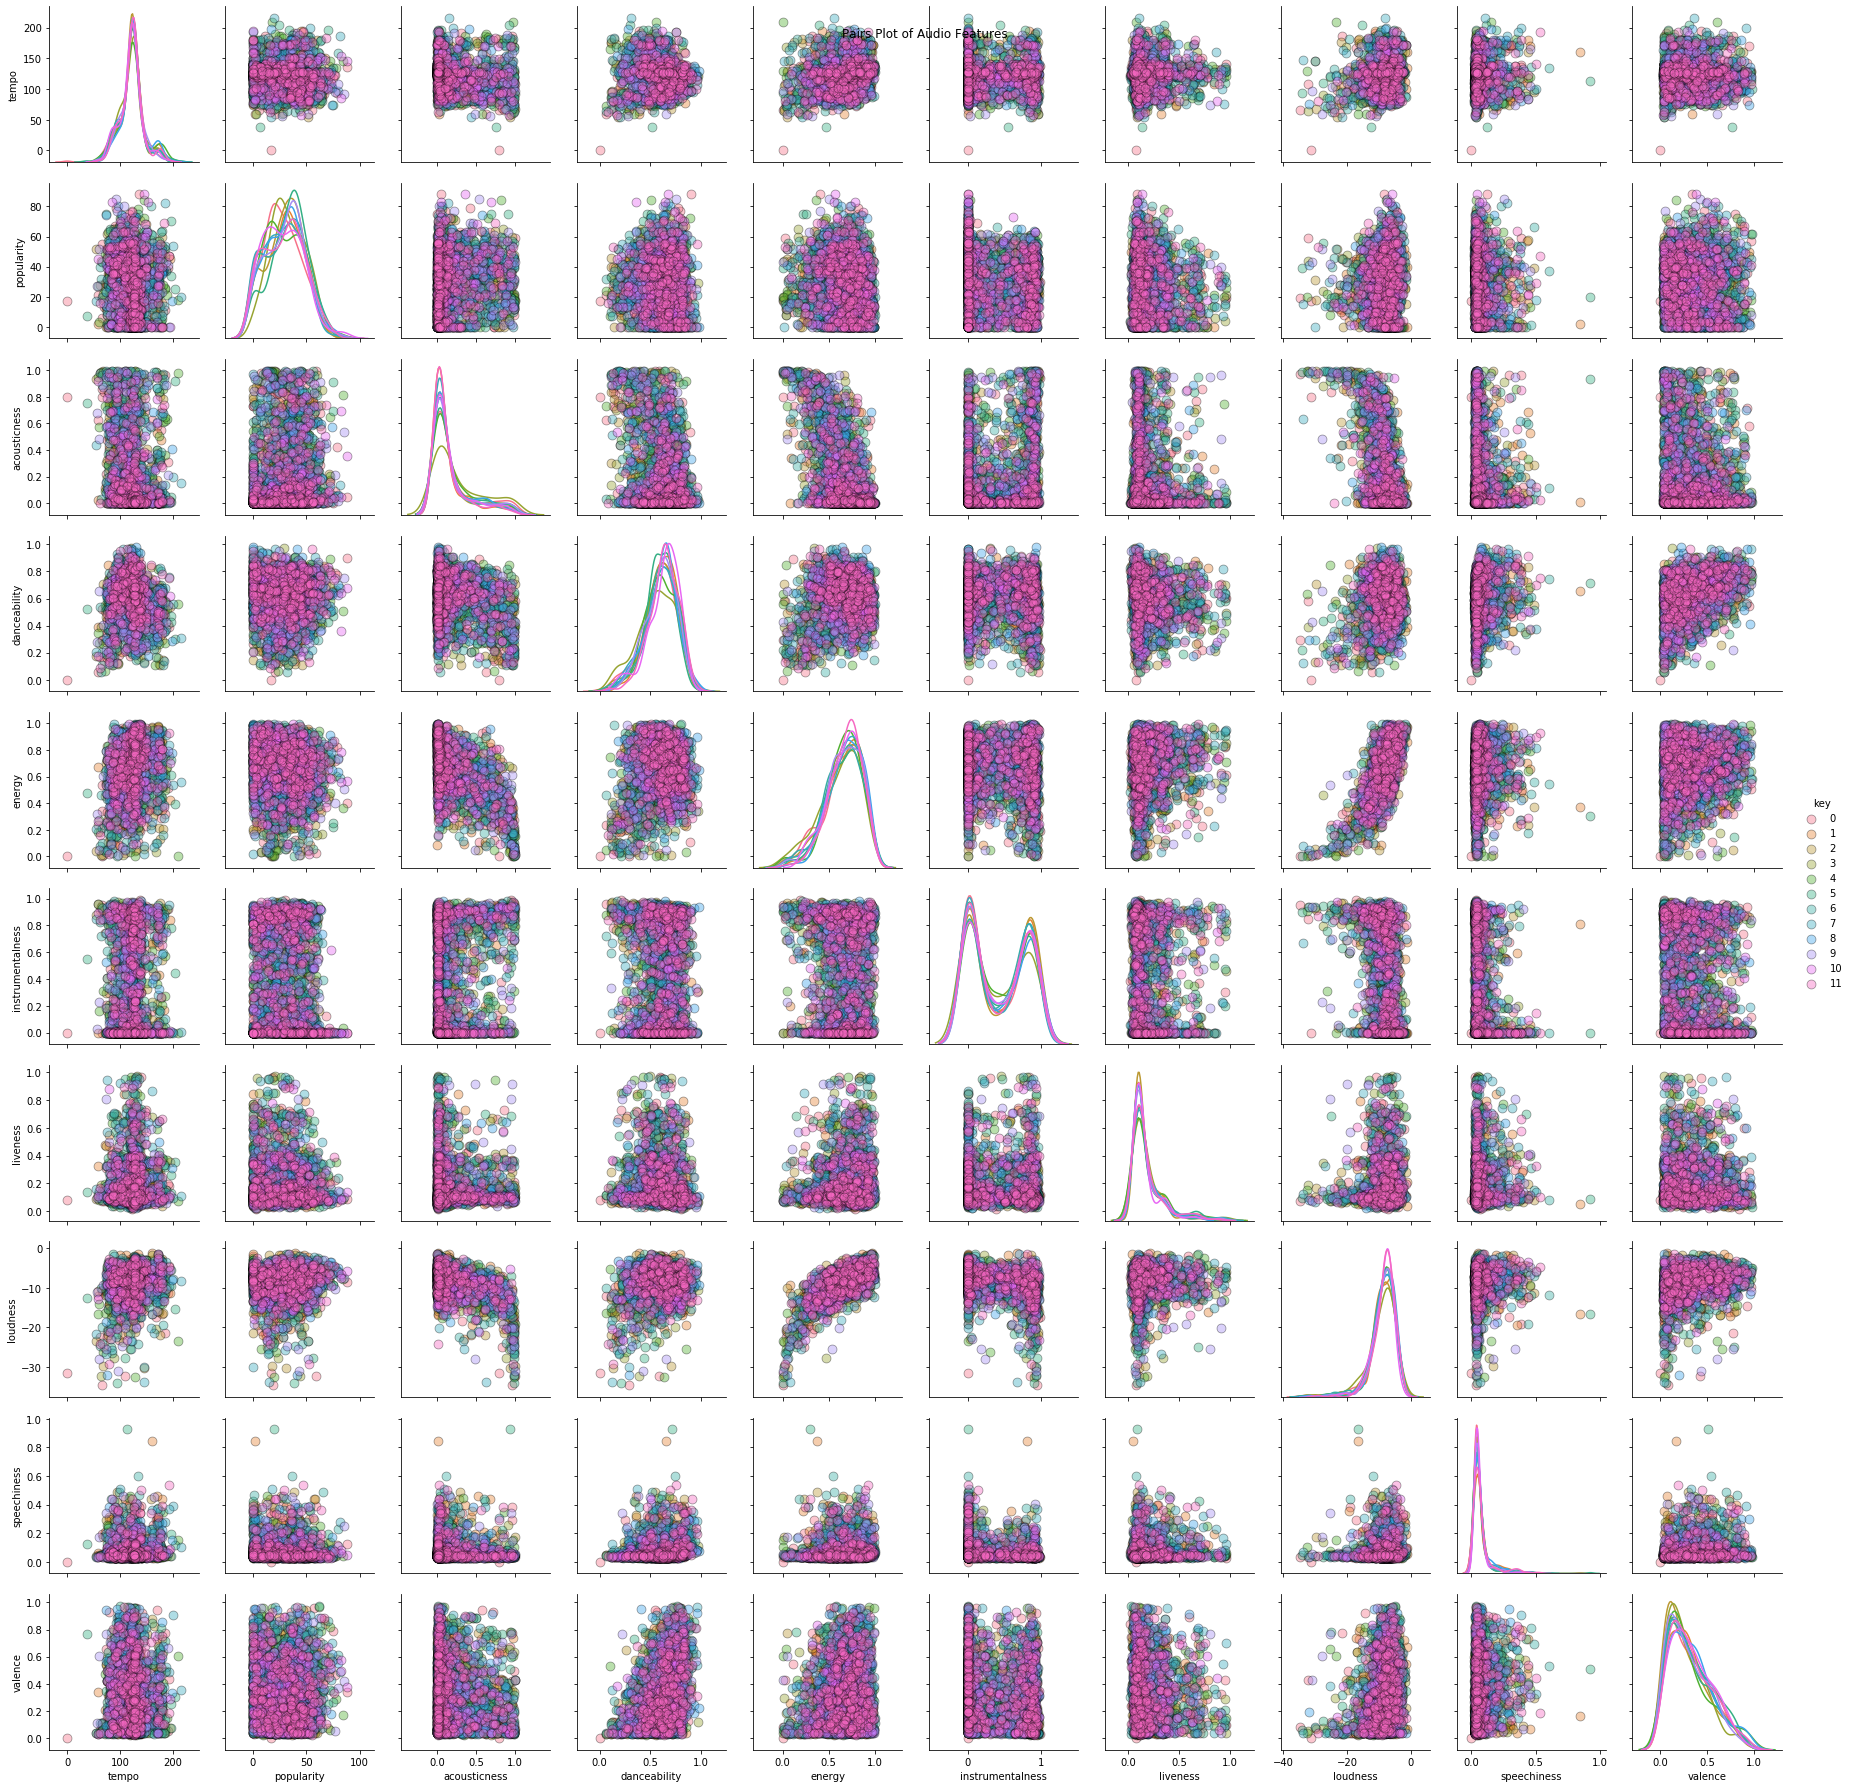

In [216]:
import seaborn as sns

# Create the default pairplot
sns.pairplot(df, hue = 'key', 
             diag_kind = 'kde',
             diag_kws = dict(shade=False),
             plot_kws = {'alpha': 0.4, 's': 80, 'edgecolor': 'k'},
             vars=['tempo', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness','valence']); 
plt.suptitle('Pairs Plot of Audio Features');

In [201]:
df.to_csv('data/SavedSongs29052019.csv')